In [278]:
from pylab import plt
import pandas as pd
import numpy as np
plt.style.use('seaborn-v0_8')
%matplotlib inline

import requests
import cufflinks
import pandas as pd
from io import StringIO
from eod import EodHistoricalData
cufflinks.set_config_file(offline=True)

import warnings
warnings.simplefilter('ignore')

from BSM_ImplVolas import call_option

In [280]:
import math
import numpy as np
from scipy.integrate import quad

def M76_characteristic_function(u, T, r, sigma, lamb, mu, delta):
    omega = r - 0.5 * sigma ** 2 - lamb * (np.exp(mu + 0.5 * delta ** 2) - 1)
    value = np.exp((1j * u * omega - 0.5 * u ** 2 * sigma ** 2 +
            lamb * (np.exp(1j * u * mu - u ** 2 * delta ** 2 * 0.5) - 1))  * T)
    return value


def M76_integration_function(u, S0, K, T, r, sigma, lamb, mu, delta):
    JDCF = M76_characteristic_function(u - 0.5 * 1j, T, r,
                                       sigma, lamb, mu, delta)
    value = 1 / (u ** 2 + 0.25) * (np.exp(1j * u * math.log(S0 / K))
                                    * JDCF).real
    return value


def M76_value_call_INT(S0, K, T, r, sigma, lamb, mu, delta):
    int_value = quad(lambda u: M76_integration_function(u, S0, K, T, r,
                    sigma, lamb, mu, delta), 0, 50, limit=250)[0]
    call_value = S0 - np.exp(-r * T) * math.sqrt(S0 * K) / math.pi * int_value
    return call_value

In [282]:
S0 = 100.0                  # initial index level
K = 100.0                   # strike level
T = 1.0                     # call option maturity
r = 0.05                    # constant short rate
sigma = 0.4                 # constant volatility of diffusion
lamb = 1.0                  # jump frequency p.a.
mu = -0.2                   # expected jump size
delta = 0.1                 # jump size volatility 

print ('Value of Call Option %8.3f' \
            % M76_value_call_INT(S0, K, T, r, sigma, lamb, mu, delta))

Value of Call Option   19.948


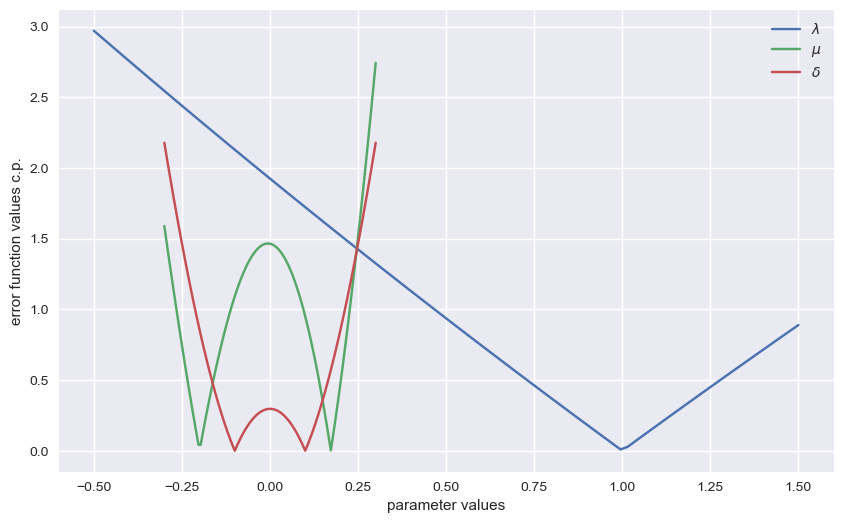

In [284]:
C0 = M76_value_call_INT(S0, K, T, r, sigma, lamb, mu, delta)
def error_function(p0):
    sigma, lamb, mu, delta = p0
    return abs(C0 - M76_value_call_INT(S0, K, T, r, sigma, lamb, mu, delta))


def plot_error_function():
    plt.figure(figsize=(10, 6))
    # Plotting (lamb)
    l = np.linspace(-0.5, 1.5, 100); EFv = []
    for i in l:
        EFv.append(error_function([sigma, i, mu, delta]))
    plt.plot(l, EFv, label='$\lambda$')
    plt.xlabel('parameter values')
    plt.ylabel('error function values c.p.')
    # Plotting (mu)
    l = np.linspace(-0.3, 0.3, 100); EFv = []
    for i in l:
        EFv.append(error_function([sigma, lamb, i, delta]))
    plt.plot(l, EFv, label='$\mu$')
    # Plotting (delta)
    l = np.linspace(-0.3, 0.3, 100); EFv = []
    for i in l:
        EFv.append(error_function([sigma, lamb, mu, i]))
    plt.plot(l, EFv, label='$\delta$')
    plt.legend(loc=0)

plot_error_function()

In [286]:
# Base Data for the EuroStoxx 50 - Jan 2024 Data Set

S0 = 4663.5                       # EuroStoxx50 level
r = 0.0379                        # Assumption (Base Rate Europe)

df = pd.read_csv('EUROStoxx50_Options_2024-01_SHORT.csv').dropna()
df['ts'] = pd.to_datetime(df['ts'], dayfirst=True)
df['Timestamp_txt'] = pd.to_datetime(df['Timestamp_txt'], dayfirst=True)
df['Maturity'] = pd.to_datetime(df['Maturity'], dayfirst=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   ts                  105 non-null    datetime64[ns]
 1   matu                105 non-null    int64         
 2   Spot                105 non-null    float64       
 3   Fwd                 105 non-null    float64       
 4   PutOrCall           105 non-null    object        
 5   StrikePrice         105 non-null    int64         
 6   ContractMultiplier  105 non-null    int64         
 7   ExerciseStyle       105 non-null    object        
 8   bid                 105 non-null    float64       
 9   ask                 105 non-null    float64       
 10  sigma               105 non-null    float64       
 11  Spread              105 non-null    float64       
 12  price               105 non-null    float64       
 13  delta               105 non-null    float64       

In [288]:
df.rename(columns={'StrikePrice': 'Strike'}, inplace=True)
df.rename(columns={'sigma': 'Imp_Vol'}, inplace=True)
df.rename(columns={'ts': 'Date'}, inplace=True)
df.rename(columns={'ask': 'Close'}, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                105 non-null    datetime64[ns]
 1   matu                105 non-null    int64         
 2   Spot                105 non-null    float64       
 3   Fwd                 105 non-null    float64       
 4   PutOrCall           105 non-null    object        
 5   Strike              105 non-null    int64         
 6   ContractMultiplier  105 non-null    int64         
 7   ExerciseStyle       105 non-null    object        
 8   bid                 105 non-null    float64       
 9   Close               105 non-null    float64       
 10  Imp_Vol             105 non-null    float64       
 11  Spread              105 non-null    float64       
 12  price               105 non-null    float64       
 13  delta               105 non-null    float64       

In [290]:
df.head()

,Date,matu,Spot,Fwd,PutOrCall,Strike,ContractMultiplier,ExerciseStyle,bid,Close,...,Spread,price,delta,vega,gamma,theta,adjust,calib_ok,Timestamp_txt,Maturity
0,2024-01-31 16:00:00,20240216,4663.5,4648.228796,Put,3475,10,European,0.1,0.3,...,0.643294,0.153939,-0.001179,0.036358,0.000004,-0.041095,0,True,2024-01-31 16:00:00,2024-02-16 16:00:00
1,2024-01-31 16:00:00,20240216,4663.5,4648.228796,Put,3500,10,European,0.1,0.3,...,0.643294,0.170336,-0.001313,0.040117,0.000004,-0.041808,0,True,2024-01-31 16:00:00,2024-02-16 16:00:00
2,2024-01-31 16:00:00,20240216,4663.5,4648.228796,Put,3525,10,European,0.1,0.3,...,0.643294,0.187740,-0.001457,0.044128,0.000005,-0.044032,0,True,2024-01-31 16:00:00,2024-02-16 16:00:00
3,2024-01-31 16:00:00,20240216,4663.5,4648.228796,Put,3550,10,European,0.1,0.3,...,0.643294,0.206145,-0.001612,0.048398,0.000005,-0.046214,0,True,2024-01-31 16:00:00,2024-02-16 16:00:00
4,2024-01-31 16:00:00,20240216,4663.5,4648.228796,Put,3575,10,European,0.1,0.3,...,0.643294,0.225541,-0.001779,0.052935,0.000005,-0.048345,0,True,2024-01-31 16:00:00,2024-02-16 16:00:00


In [292]:
df.tail()

,Date,matu,Spot,Fwd,PutOrCall,Strike,ContractMultiplier,ExerciseStyle,bid,Close,...,Spread,price,delta,vega,gamma,theta,adjust,calib_ok,Timestamp_txt,Maturity
100,2024-01-31 16:00:00,20240216,4663.5,4648.228796,Put,5075,10,European,424.2,426.3,...,0.643294,425.354998,-0.989897,0.140853,0.000039,-0.049444,0,True,2024-01-31 16:00:00,2024-02-16 16:00:00
101,2024-01-31 16:00:00,20240216,4663.5,4648.228796,Call,5100,10,European,0.1,0.3,...,0.643294,0.229204,0.004501,0.122255,0.000030,-0.040331,0,True,2024-01-31 16:00:00,2024-02-16 16:00:00
102,2024-01-31 16:00:00,20240216,4663.5,4648.228796,Put,5100,10,European,449.1,451.2,...,0.643294,450.276445,-0.990672,0.122255,0.000030,-0.040331,0,True,2024-01-31 16:00:00,2024-02-16 16:00:00
103,2024-01-31 16:00:00,20240216,4663.5,4648.228796,Call,5125,10,European,0.1,0.3,...,0.643294,0.203125,0.003910,0.107776,0.000026,-0.037500,0,True,2024-01-31 16:00:00,2024-02-16 16:00:00
104,2024-01-31 16:00:00,20240216,4663.5,4648.228796,Put,5125,10,European,474.0,476.1,...,0.643294,475.206444,-0.991264,0.107776,0.000026,-0.037500,0,True,2024-01-31 16:00:00,2024-02-16 16:00:00


In [294]:
markers = ['.', 'o', '^', 'v', 'x', 'D', 'd', '>', '<']

In [296]:
def plot_imp_vols(data):
    ''' Plot the implied volatilites. '''
    maturities = sorted(set(data['Maturity']))
    plt.figure(figsize=(10, 6))
    for i, mat in enumerate(maturities):
        dat = data[(data['Maturity'] == mat) & (data['Imp_Vol'] > 0)]
        plt.plot(dat['Strike'].values, dat['Imp_Vol'].values,
                 'b%s' % markers[i], label=str(mat)[:10])
    plt.grid(True)
    plt.legend()
    plt.xlabel('strike')
    plt.ylabel('implied volatility')
    plt.show()

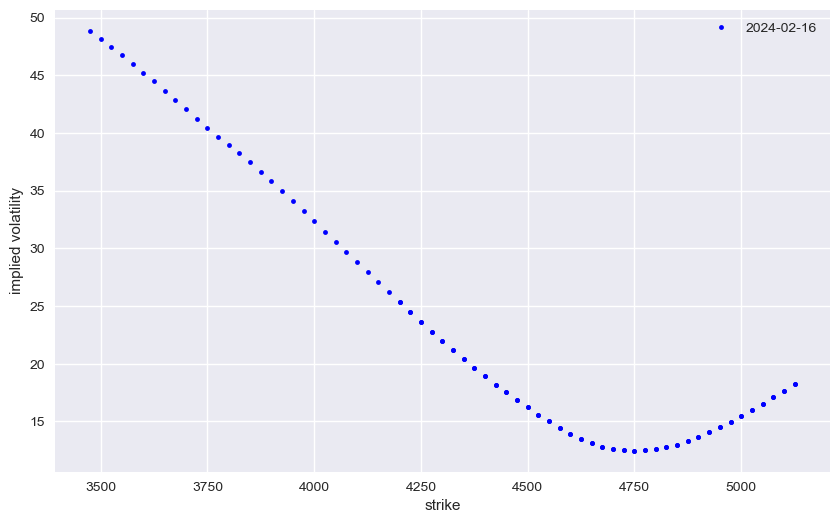

In [298]:
# Implied Volas from Base Data for EuroStoxx 50 Options - Jan 2024
plot_imp_vols(df)

In [300]:
# Separation of Puts & Call in Imp Vola Plot ---------------------------- #

def plot_imp_vols_sep(data):
    ''' Plot the implied volatilites. '''
    maturities = sorted(set(data['Maturity']))
    plt.figure(figsize=(10, 6))
    for i, mat in enumerate(maturities):
        dat = data[(data['Maturity'] == mat) & (data['Imp_Vol'] > 0) & (data['PutOrCall'] == 'Call')]
        plt.plot(dat['Strike'].values, dat['Imp_Vol'].values,
                 'r%s' % markers[i], label=str('CALLS')[:10])
    for i, mat in enumerate(maturities):
        dat = data[(data['Maturity'] == mat) & (data['Imp_Vol'] > 0) & (data['PutOrCall'] == 'Put')]
        plt.plot(dat['Strike'].values, dat['Imp_Vol'].values,
                 'b%s' % markers[i], label=str('PUTS')[:10])
    plt.grid(True)
    plt.legend()
    plt.xlabel('Strike')
    plt.ylabel('Implied Volatility')
    plt.tight_layout()
    plt.savefig('Imp_Volas_EUROStoxx50_Jan 24_Base Data.png')

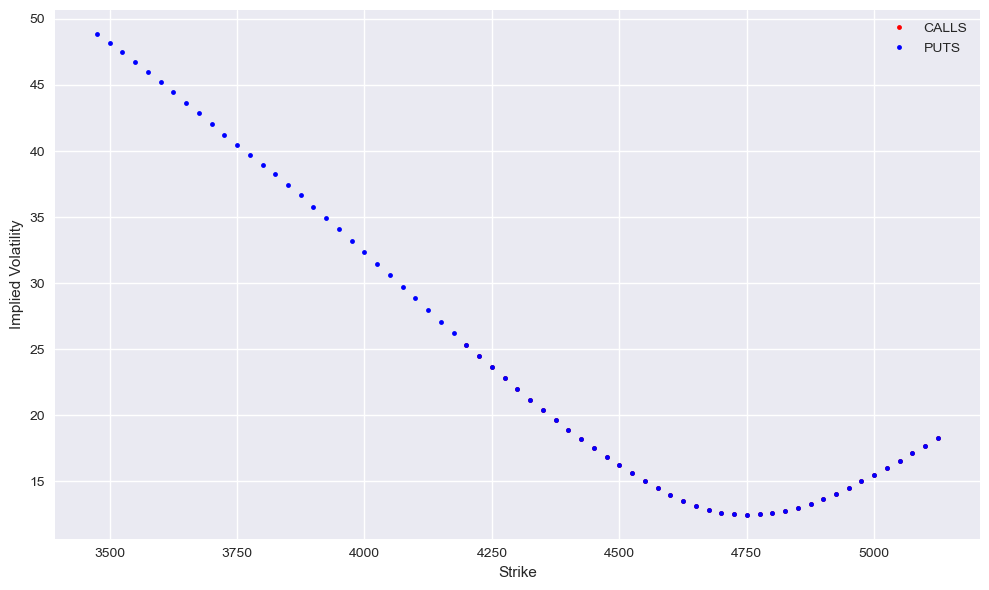

In [302]:
plot_imp_vols_sep(df)

In [304]:
Calls = df['PutOrCall'] == 'Call'
Puts = df['PutOrCall'] == 'Put'

df_call = df[~Puts]
df_put = df[~Calls]

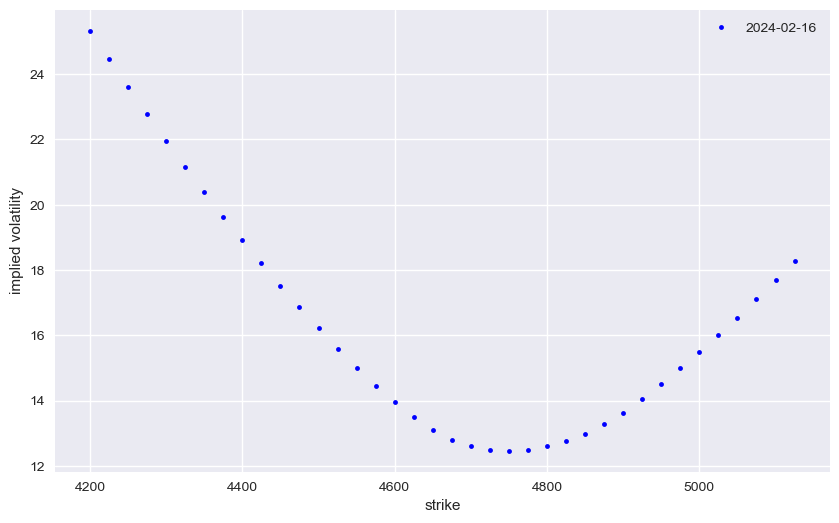

In [306]:
plot_imp_vols(df_call)

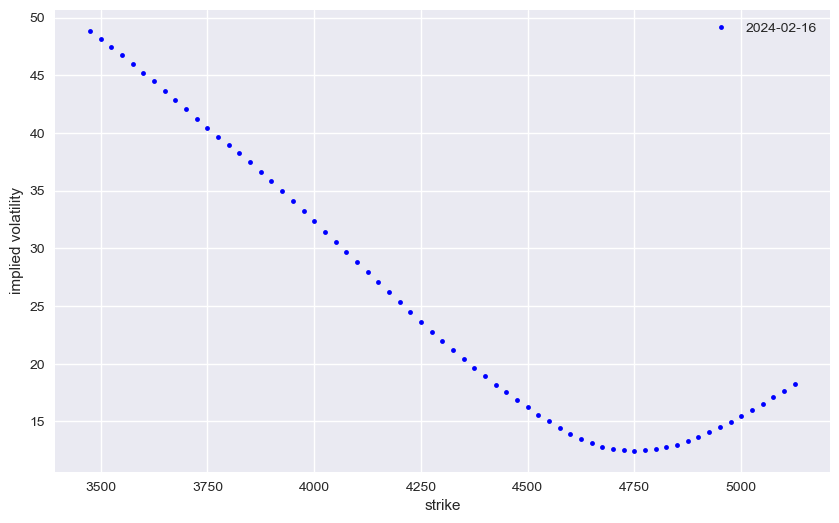

In [308]:
plot_imp_vols(df_put)

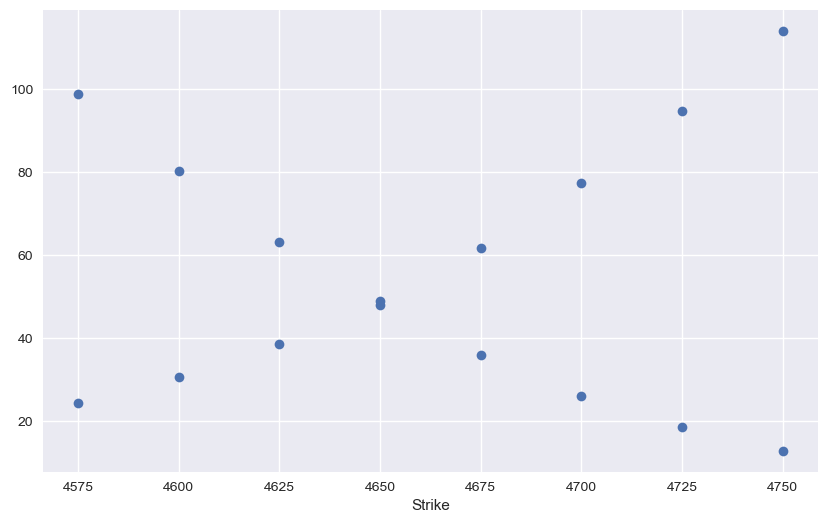

In [310]:
# Option Selection (from Calls & Puts)
tol = 0.02
options = df[(np.abs(df['Strike'] - S0) / S0) < tol]
mats = sorted(set(options['Maturity']))
options = options[options['Maturity'] == mats[0]]
options

options.set_index('Strike')['Close'].plot(style='o', figsize=(10, 6));

In [312]:
# Option Selection (from Calls only)
tol = 0.02
options_call = df_call[(np.abs(df_call['Strike'] - S0) / S0) < tol]
mats = sorted(set(options_call['Maturity']))
options_call = options_call[options_call['Maturity'] == mats[0]]
options_call

,Date,matu,Spot,Fwd,PutOrCall,Strike,ContractMultiplier,ExerciseStyle,bid,Close,...,Spread,price,delta,vega,gamma,theta,adjust,calib_ok,Timestamp_txt,Maturity
59,2024-01-31 16:00:00,20240216,4663.5,4648.228796,Call,4575,10,European,97.2,98.8,...,0.643294,97.953073,0.713106,3.130463,0.002249,-2.028577,0,True,2024-01-31 16:00:00,2024-02-16 16:00:00
61,2024-01-31 16:00:00,20240216,4663.5,4648.228796,Call,4600,10,European,78.7,80.2,...,0.643294,79.434832,0.650891,3.409744,0.002640,-2.218752,0,True,2024-01-31 16:00:00,2024-02-16 16:00:00
63,2024-01-31 16:00:00,20240216,4663.5,4648.228796,Call,4625,10,European,62.0,63.2,...,0.643294,62.629017,0.579289,3.609876,0.002992,-2.351465,0,True,2024-01-31 16:00:00,2024-02-16 16:00:00
65,2024-01-31 16:00:00,20240216,4663.5,4648.228796,Call,4650,10,European,47.5,48.0,...,0.643294,47.908902,0.500022,3.688184,0.003237,-2.398048,0,True,2024-01-31 16:00:00,2024-02-16 16:00:00
67,2024-01-31 16:00:00,20240216,4663.5,4648.228796,Call,4675,10,European,35.2,35.8,...,0.643294,35.576919,0.416953,3.611920,0.003301,-2.335657,0,True,2024-01-31 16:00:00,2024-02-16 16:00:00
69,2024-01-31 16:00:00,20240216,4663.5,4648.228796,Call,4700,10,European,25.5,26.0,...,0.643294,25.681417,0.335391,3.376006,0.003152,-2.160421,0,True,2024-01-31 16:00:00,2024-02-16 16:00:00
71,2024-01-31 16:00:00,20240216,4663.5,4648.228796,Call,4725,10,European,18.0,18.5,...,0.643294,18.091011,0.260593,3.009779,0.002820,-1.899803,0,True,2024-01-31 16:00:00,2024-02-16 16:00:00
73,2024-01-31 16:00:00,20240216,4663.5,4648.228796,Call,4750,10,European,12.4,12.8,...,0.643294,12.486850,0.196229,2.566201,0.002378,-1.594434,0,True,2024-01-31 16:00:00,2024-02-16 16:00:00


<Axes: xlabel='Strike'>

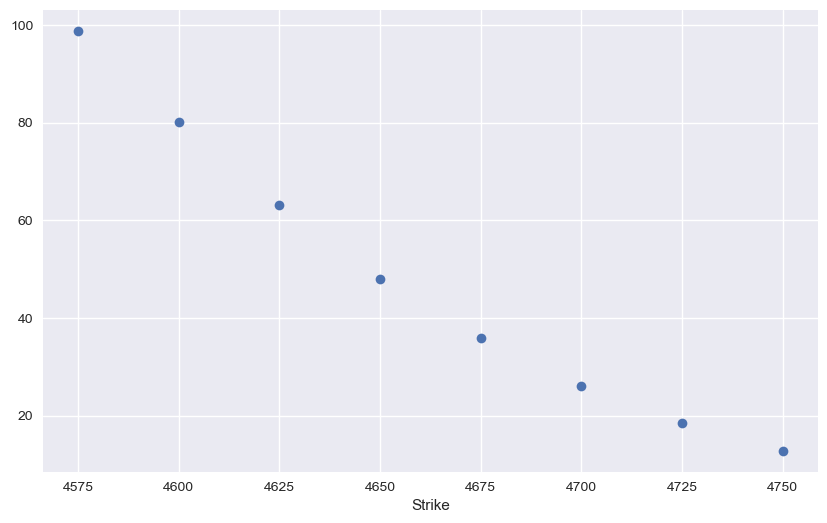

In [314]:
options_call.set_index('Strike')['Close'].plot(style='o', figsize=(10, 6))

<Axes: xlabel='Strike'>

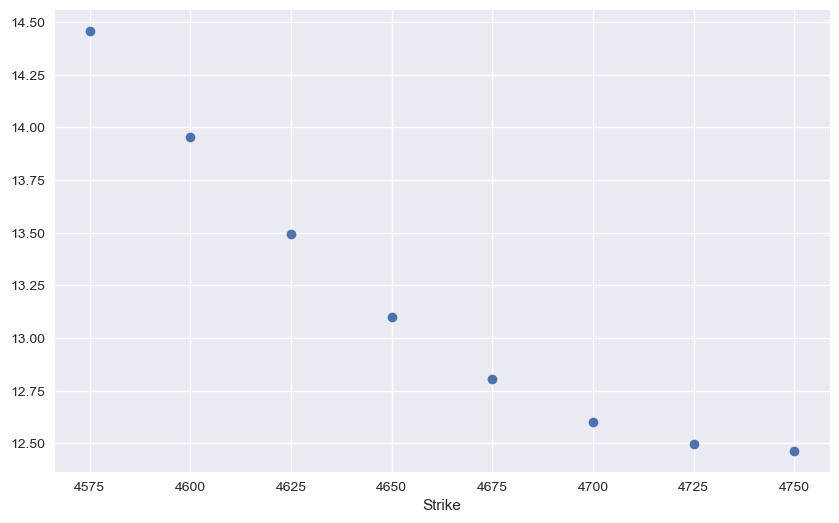

In [316]:
options_call.set_index('Strike')['Imp_Vol'].plot(style='o', figsize=(10, 6))

In [318]:
i = 0; min_RMSE = 100.
def M76_error_function(p0):
    global i, min_RMSE
    sigma, lamb, mu, delta = p0
    if sigma < 0.0 or delta < 0.0 or lamb < 0.0:
        return 500.0
    se = []
    for row, option in options_call.iterrows():
        T = (option['Maturity'] - option['Date']).days / 365.
        model_value = M76_value_call_INT(S0, option['Strike'], T,
                                         r, sigma, lamb, mu, delta)
        se.append((model_value - option['Close']) ** 2)
    RMSE = math.sqrt(sum(se) / len(se))
    min_RMSE = min(min_RMSE, RMSE)
    if i % 100 == 0:
        print ('%4d |' % i, np.array(p0), '| %7.3f | %7.3f' % (RMSE, min_RMSE))
    i += 1
    return RMSE

In [320]:
%%time
import scipy.optimize as sop
np.set_printoptions(suppress=True,
                    formatter={'all': lambda x: '%6.3f' % x})
p0 = sop.brute(M76_error_function, ((0.10, 0.25, 0.025),
                   (0.10, 0.80, 0.10), (-0.40, 0.00, 0.10),
                   (0.00, 0.12, 0.02)), finish=None)

   0 | [ 0.100  0.100 -0.400  0.000] |   9.583 |   9.583
 100 | [ 0.100  0.500 -0.400  0.080] |  24.318 |   6.923
 200 | [ 0.125  0.200 -0.300  0.040] |  18.214 |   6.923
 300 | [ 0.125  0.600 -0.200  0.000] |  23.648 |   6.923
 400 | [ 0.150  0.300 -0.200  0.080] |  25.808 |   6.923
 500 | [ 0.150  0.700 -0.100  0.040] |  25.977 |   6.923
 600 | [ 0.175  0.500 -0.400  0.000] |  46.309 |   6.923
 700 | [ 0.200  0.200 -0.400  0.080] |  44.565 |   6.923
 800 | [ 0.200  0.600 -0.300  0.040] |  53.207 |   6.923
 900 | [ 0.225  0.300 -0.200  0.000] |  51.928 |   6.923
1000 | [ 0.225  0.700 -0.200  0.080] |  58.137 |   6.923
CPU times: total: 9.17 s
Wall time: 24.7 s


In [322]:
%%time
opt = sop.fmin(M76_error_function, p0, xtol=0.00001,
                    ftol=0.00001, maxiter=750, maxfun=1500)

1100 | [ 0.056  0.231  0.118  0.156] |   1.141 |   1.141
1200 | [ 0.037  0.276  0.174  0.181] |   0.726 |   0.726
1300 | [ 0.033  0.186  0.213  0.302] |   0.689 |   0.689
1400 | [ 0.033  0.139  0.255  0.387] |   0.683 |   0.683
1500 | [ 0.033  0.138  0.256  0.388] |   0.683 |   0.683
1600 | [ 0.031  0.201  0.195  0.305] |   0.678 |   0.677
1700 | [ 0.005  0.399  0.100  0.226] |   0.634 |   0.633
1800 | [ 0.004  0.401  0.102  0.225] |   0.633 |   0.633
1900 | [ 0.006  0.355  0.111  0.248] |   0.628 |   0.628
2000 | [ 0.000  0.269  0.119  0.327] |   0.612 |   0.611
2100 | [ 0.000  0.223  0.137  0.379] |   0.602 |   0.602
2200 | [ 0.002  0.179  0.141  0.465] |   0.594 |   0.594
CPU times: total: 9.38 s
Wall time: 29.1 s


In [324]:
i = 0
M76_error_function(p0)

   0 | [ 0.100  0.100 -0.100  0.040] |   6.923 |   0.594


6.923270781241846

In [326]:
i = 0
M76_error_function(opt)

   0 | [ 0.002  0.175  0.140  0.475] |   0.594 |   0.594


0.5940452222709655

In [328]:
def generate_plot(opt, options_call):
    sigma, lamb, mu, delta = opt
    options_call['Model'] = 0.0
    for row, option in options_call.iterrows():
        T = (option['Maturity'] - option['Date']).days / 365.
        options_call.loc[row, 'Model'] = M76_value_call_INT(S0, option['Strike'],
                                    T, r, sigma, lamb, mu, delta)
    options_call = options_call.set_index('Strike')
    fig, ax = plt.subplots(2, sharex=True, figsize=(8, 7))
    options_call[['Close', 'Model']].plot(style=['b-', 'ro'],
                    title='%s' % str(option['Maturity'])[:10], ax=ax[0])
    ax[0].set_ylabel('option values')
    xv = options_call.index.values
    ax[1] = plt.bar(xv - 5 / 2., options_call['Model'] - options_call['Close'], 
                    width=5)
    plt.ylabel('difference')
    plt.xlim(min(xv) - 10, max(xv) + 10)
    plt.tight_layout()

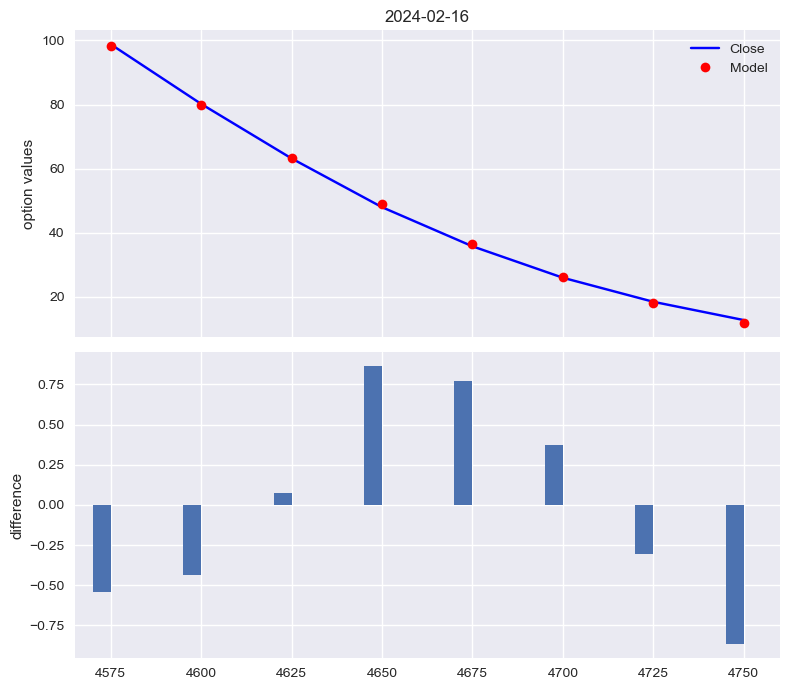

In [330]:
generate_plot(opt, options_call)

In [332]:
options_call

,Date,matu,Spot,Fwd,PutOrCall,Strike,ContractMultiplier,ExerciseStyle,bid,Close,...,price,delta,vega,gamma,theta,adjust,calib_ok,Timestamp_txt,Maturity,Model
59,2024-01-31 16:00:00,20240216,4663.5,4648.228796,Call,4575,10,European,97.2,98.8,...,97.953073,0.713106,3.130463,0.002249,-2.028577,0,True,2024-01-31 16:00:00,2024-02-16 16:00:00,98.255307
61,2024-01-31 16:00:00,20240216,4663.5,4648.228796,Call,4600,10,European,78.7,80.2,...,79.434832,0.650891,3.409744,0.002640,-2.218752,0,True,2024-01-31 16:00:00,2024-02-16 16:00:00,79.764448
63,2024-01-31 16:00:00,20240216,4663.5,4648.228796,Call,4625,10,European,62.0,63.2,...,62.629017,0.579289,3.609876,0.002992,-2.351465,0,True,2024-01-31 16:00:00,2024-02-16 16:00:00,63.274304
65,2024-01-31 16:00:00,20240216,4663.5,4648.228796,Call,4650,10,European,47.5,48.0,...,47.908902,0.500022,3.688184,0.003237,-2.398048,0,True,2024-01-31 16:00:00,2024-02-16 16:00:00,48.866573
67,2024-01-31 16:00:00,20240216,4663.5,4648.228796,Call,4675,10,European,35.2,35.8,...,35.576919,0.416953,3.611920,0.003301,-2.335657,0,True,2024-01-31 16:00:00,2024-02-16 16:00:00,36.572219
69,2024-01-31 16:00:00,20240216,4663.5,4648.228796,Call,4700,10,European,25.5,26.0,...,25.681417,0.335391,3.376006,0.003152,-2.160421,0,True,2024-01-31 16:00:00,2024-02-16 16:00:00,26.371424
71,2024-01-31 16:00:00,20240216,4663.5,4648.228796,Call,4725,10,European,18.0,18.5,...,18.091011,0.260593,3.009779,0.002820,-1.899803,0,True,2024-01-31 16:00:00,2024-02-16 16:00:00,18.195711
73,2024-01-31 16:00:00,20240216,4663.5,4648.228796,Call,4750,10,European,12.4,12.8,...,12.486850,0.196229,2.566201,0.002378,-1.594434,0,True,2024-01-31 16:00:00,2024-02-16 16:00:00,11.932025


In [334]:
def calc_imp_vols(data):
    data['Imp_Vol_Mod'] = 0.0
    data['Imp_Vol_Mar'] = 0.0
    tol = 0.30  # tolerance for moneyness
    for row in data.index:
        t = data['Date'][row]
        T = data['Maturity'][row]
        ttm = (T - t).days / 365.
        forward = np.exp(r * ttm) * S0
        if (abs(data['Strike'][row] - forward) / forward) < tol:
            call = call_option(S0, data['Strike'][row], t, T, r, 0.2)
            data['Imp_Vol_Mod'][row] = call.imp_vol(data['Model'][row])
            data['Imp_Vol_Mar'][row] = call.imp_vol(data['Close'][row])
    return data

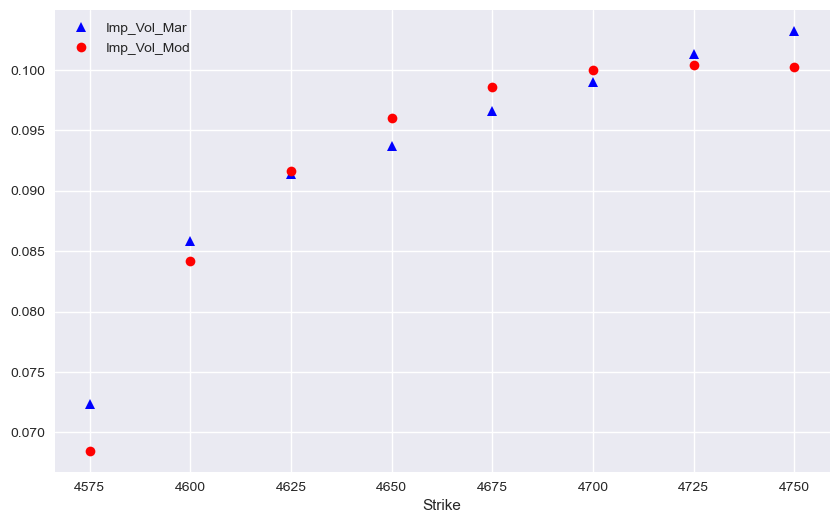

In [336]:
options = calc_imp_vols(options_call)
options.set_index('Strike')[['Imp_Vol_Mar', 'Imp_Vol_Mod']].plot(
                figsize=(10, 6), style=['b^', 'ro']);

In [338]:
options

,Date,matu,Spot,Fwd,PutOrCall,Strike,ContractMultiplier,ExerciseStyle,bid,Close,...,vega,gamma,theta,adjust,calib_ok,Timestamp_txt,Maturity,Model,Imp_Vol_Mod,Imp_Vol_Mar
59,2024-01-31 16:00:00,20240216,4663.5,4648.228796,Call,4575,10,European,97.2,98.8,...,3.130463,0.002249,-2.028577,0,True,2024-01-31 16:00:00,2024-02-16 16:00:00,98.255307,0.068482,0.072315
61,2024-01-31 16:00:00,20240216,4663.5,4648.228796,Call,4600,10,European,78.7,80.2,...,3.409744,0.002640,-2.218752,0,True,2024-01-31 16:00:00,2024-02-16 16:00:00,79.764448,0.084220,0.085855
63,2024-01-31 16:00:00,20240216,4663.5,4648.228796,Call,4625,10,European,62.0,63.2,...,3.609876,0.002992,-2.351465,0,True,2024-01-31 16:00:00,2024-02-16 16:00:00,63.274304,0.091622,0.091403
65,2024-01-31 16:00:00,20240216,4663.5,4648.228796,Call,4650,10,European,47.5,48.0,...,3.688184,0.003237,-2.398048,0,True,2024-01-31 16:00:00,2024-02-16 16:00:00,48.866573,0.095979,0.093690
67,2024-01-31 16:00:00,20240216,4663.5,4648.228796,Call,4675,10,European,35.2,35.8,...,3.611920,0.003301,-2.335657,0,True,2024-01-31 16:00:00,2024-02-16 16:00:00,36.572219,0.098577,0.096594
69,2024-01-31 16:00:00,20240216,4663.5,4648.228796,Call,4700,10,European,25.5,26.0,...,3.376006,0.003152,-2.160421,0,True,2024-01-31 16:00:00,2024-02-16 16:00:00,26.371424,0.099956,0.098963
71,2024-01-31 16:00:00,20240216,4663.5,4648.228796,Call,4725,10,European,18.0,18.5,...,3.009779,0.002820,-1.899803,0,True,2024-01-31 16:00:00,2024-02-16 16:00:00,18.195711,0.100419,0.101319
73,2024-01-31 16:00:00,20240216,4663.5,4648.228796,Call,4750,10,European,12.4,12.8,...,2.566201,0.002378,-1.594434,0,True,2024-01-31 16:00:00,2024-02-16 16:00:00,11.932025,0.100226,0.103233


In [340]:
options_call['Imp_Vol'] = options_call['Imp_Vol'] / 100

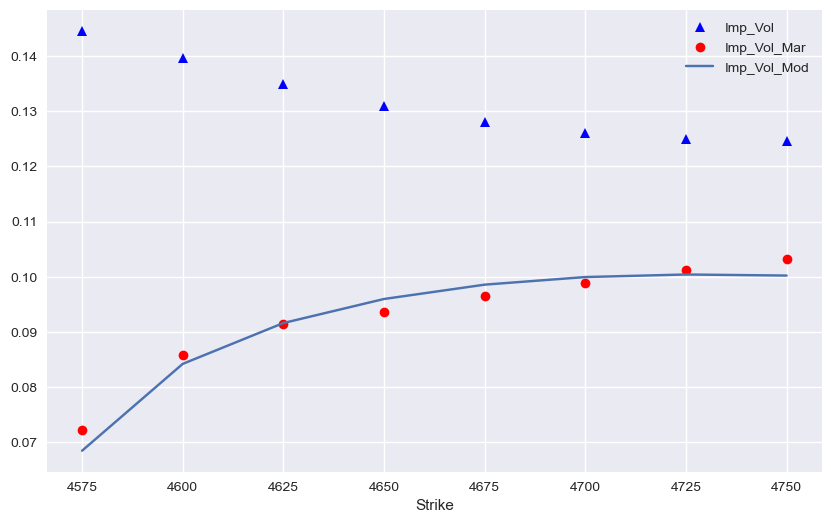

In [342]:
options.set_index('Strike')[['Imp_Vol', 'Imp_Vol_Mar', 'Imp_Vol_Mod']].plot(
                figsize=(10, 6), style=['b^', 'ro']);

In [344]:
options.head()

,Date,matu,Spot,Fwd,PutOrCall,Strike,ContractMultiplier,ExerciseStyle,bid,Close,...,vega,gamma,theta,adjust,calib_ok,Timestamp_txt,Maturity,Model,Imp_Vol_Mod,Imp_Vol_Mar
59,2024-01-31 16:00:00,20240216,4663.5,4648.228796,Call,4575,10,European,97.2,98.8,...,3.130463,0.002249,-2.028577,0,True,2024-01-31 16:00:00,2024-02-16 16:00:00,98.255307,0.068482,0.072315
61,2024-01-31 16:00:00,20240216,4663.5,4648.228796,Call,4600,10,European,78.7,80.2,...,3.409744,0.002640,-2.218752,0,True,2024-01-31 16:00:00,2024-02-16 16:00:00,79.764448,0.084220,0.085855
63,2024-01-31 16:00:00,20240216,4663.5,4648.228796,Call,4625,10,European,62.0,63.2,...,3.609876,0.002992,-2.351465,0,True,2024-01-31 16:00:00,2024-02-16 16:00:00,63.274304,0.091622,0.091403
65,2024-01-31 16:00:00,20240216,4663.5,4648.228796,Call,4650,10,European,47.5,48.0,...,3.688184,0.003237,-2.398048,0,True,2024-01-31 16:00:00,2024-02-16 16:00:00,48.866573,0.095979,0.093690
67,2024-01-31 16:00:00,20240216,4663.5,4648.228796,Call,4675,10,European,35.2,35.8,...,3.611920,0.003301,-2.335657,0,True,2024-01-31 16:00:00,2024-02-16 16:00:00,36.572219,0.098577,0.096594


In [376]:
def plot_implied_volatilities(options, model):
    ''' Plots market implied volatilities against model implied ones. '''
    mats = sorted(set(options.Maturity))
    for mat in mats:
        opts = options[options.Maturity == mat]
        plt.figure(figsize=(8, 6))
        plt.subplot(211)
        plt.ylabel('Implied Volatility')
        plt.xlabel('Strike')
        plt.plot(opts.Strike, opts.Imp_Vol, 'b', label='Market', lw=1.5)
        plt.plot(opts.Strike, opts.Imp_Vol_Mod, 'ro', label='Model')
        plt.legend(loc=0)
        plt.axis([min(opts.Strike) - 10, max(opts.Strike) + 10,
              min(opts.Imp_Vol) - 0.08, max(opts.Imp_Vol) + 0.08])
        plt.title('Maturity %s' % str(mat)[:10])
        plt.subplot(212)
        wi = 5.0
        diffs = opts.Imp_Vol_Mod.values - opts.Imp_Vol.values
        plt.bar(opts.Strike, diffs, width=wi)
        plt.ylabel('difference')
        plt.xlabel('Strike')
        ymi = min(diffs) - (max(diffs) - min(diffs)) * 0.5
        yma = max(diffs) + (max(diffs) - min(diffs)) * 0.5
        plt.axis([min(opts.Strike) - 10, max(opts.Strike) + 10, ymi, yma])
        plt.tight_layout()
        plt.savefig('Imp_Volas_EUROStoxx_24_M76.png')

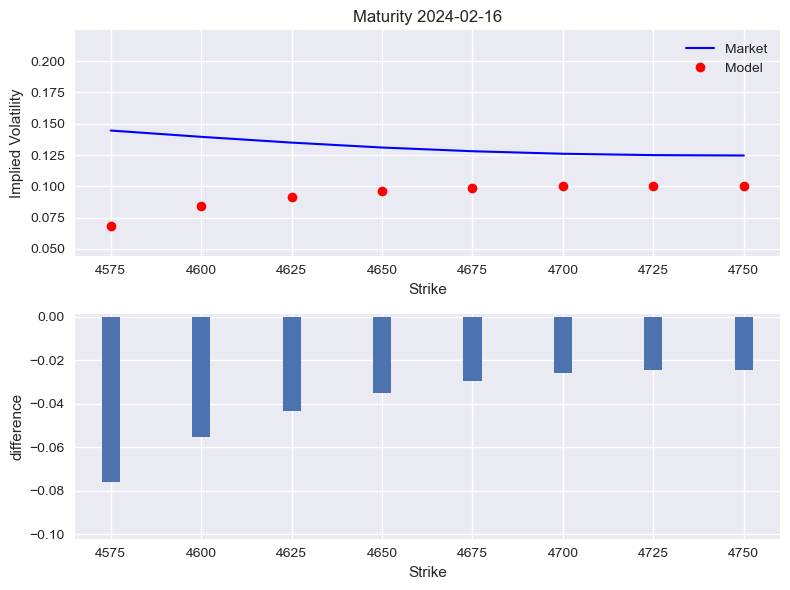

In [378]:
plot_implied_volatilities(options, 'BCC97')

In [380]:
# Subplots incl Delta View on Option Prices Comparison - Market vs Model


def plot_market_model_valuation(options, model):
    ''' Plots market implied volatilities against model implied ones. '''
    mats = sorted(set(options.Maturity))
    for mat in mats:
        opts = options[options.Maturity == mat]
        plt.figure(figsize=(8, 6))
        plt.subplot(211)
        plt.ylabel('Option prices')
        plt.plot(opts.Strike, opts.Close, 'b', label='market', lw=1.5)
        plt.plot(opts.Strike, opts.Model, 'ro', label='model')
        plt.legend(loc=0)
        plt.axis([min(opts.Strike) - 10, max(opts.Strike) + 10,
              min(opts.Close) - 20, max(opts.Close) + 20])
        plt.title('Maturity %s' % str(mat)[:10])
        plt.subplot(212)
        wi = 5.0
        diffs = opts.Close.values - opts.Model.values
        plt.bar(opts.Strike, diffs, width=wi)
        plt.ylabel('difference')
        ymi = min(diffs) - (max(diffs) - min(diffs)) * 0.1
        yma = max(diffs) + (max(diffs) - min(diffs)) * 0.1
        plt.axis([min(opts.Strike) - 10, max(opts.Strike) + 10, ymi, yma])
        plt.tight_layout()
        plt.savefig('Valuation_EuroStoxx_24_M76.png')

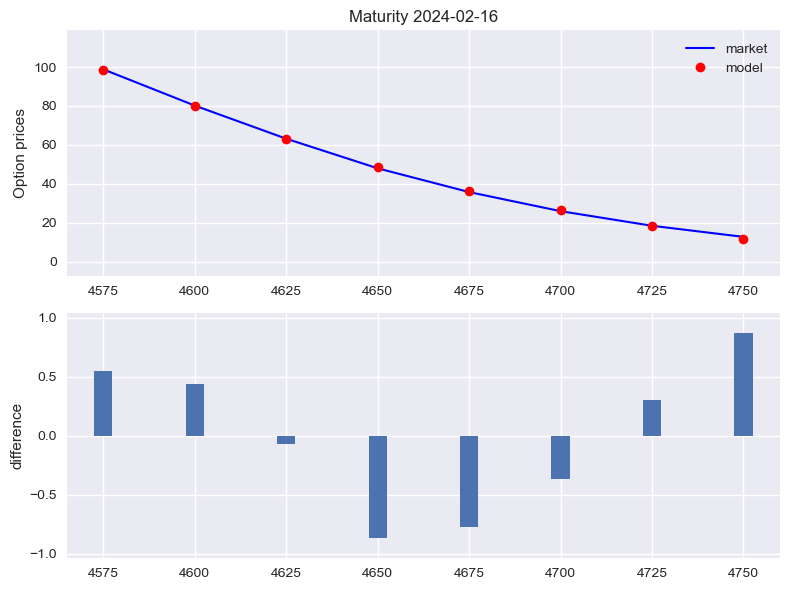

In [382]:
plot_market_model_valuation(options, 'BCC97')